## Задача 1:
* Проведите аналитику полученных данных
* Подготовьте данные для регрессионной модели
* Обучите регрессионную модель и осуществите прогноз на последний месяц для поля SALES
* Оцените качество модели с помощью функции metric

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import make_scorer
from sklearn.model_selection import ParameterGrid

import lightgbm as lgb

In [2]:
def metric(y_true, y_pred):
    
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100

In [3]:
custom_scorer = make_scorer(metric, greater_is_better=False)

Зададим функции для автоматизации валидации и отображения результатов

In [4]:
def plot_line(x, y, y2=[], title='', xlabel='', ylabel=''):
    '''
    Функция строит графики зависимости выбранных метрик исследуемой модели от значения одного гиперпараметра
    Вход:
    - х - значения аргумента (гиперпараметра)
    - y - значения функции 1 (метрика при кросс-валидации)
    - y2 - значения функции 2 (метрика на обучающей выборке)
    - title - подпись графика (название модели)
    - xlabel - подпись оси Х (название изменяемого гиперпараметра)
    - ylabel - подпись оси Y (название метрики)
    '''
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(x, y, marker='.', label='valid')
    if len(y2):
        ax.plot(x, y2, marker='.', label='train')
    ax.grid()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [5]:
def plot_heatmap(x1, x2, y, title='', label=['','']):
    '''
    функция строик график типа "heatmap" зависимости качества исследуемой модели от значений двух гиперпараметров
    х1 - значения гиперпараметра 1
    х2 - значения гиперпараметра 2
    y - значение метрики в виде одномерного массива (результат работы функции GridSearchCV.cv_results_['...'])
    title - название модели (подпись графика)
    label - массив с названиями двух гиперпараметров (подписи осей Х и Y)
    '''
    
    xsize = len(x1) if len(x1)<16 else 16
    ysize = len(x2) if len(x2)<16 else 16
    fig, ax = plt.subplots(figsize=(xsize,ysize))
    im = ax.imshow(y, cmap='coolwarm')
    plt.title(title)
    
    cax = fig.add_axes([ax.get_position().x1+0.05, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(im, cax=cax)

    ax.set_xticks(range(len(x1)))
    ax.set_yticks(range(len(x2)))
    ax.set_xticklabels(x1)
    ax.set_yticklabels(x2)
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])

    y = y.round(3)
    for i in range(len(x1)):
        for j in range(len(x2)):
            text = ax.text(i, j, y[j, i], ha="center", va="center", color="k", fontsize=8) 
    plt.show()

In [6]:
def gridSearch(X_train, y_train, X_test, y_test, model, scoring=[], params={},  
               check_train=False, verbose=None, plot_time=False, metric_error=True):
    
    res = []
    res_train = []
    
    # перебор гиперпараметров по сетке
    grid = list(ParameterGrid(params))
    for g in grid:
        model.set_params(**g)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        res.append(metric(y_test, pred))
        if check_train:
            pred_train = model.predict(X_train)
            res_train.append(metric(y_train, pred_train))

    # график
    params_values = list(params.values())
    params_keys = list(params.keys())
    if len(params_keys)==1:
        plot_line(params_values[0], res, res_train, title='', xlabel=params_keys[0], ylabel=scoring)
    elif len(params_keys)==2:
        # располагаем параметры в алфавитном порядке, чтобы совпало с выходом GridSearchCV
        if params_keys[1] < params_keys[0]:
            params_values = [params_values[1], params_values[0]]
            params_keys = [params_keys[1], params_keys[0]]
        len_p1 = len(params_values[0])
        len_p2 = len(params_values[1])
        hmap_res = np.reshape(res, (len_p1, len_p2)).T
        plot_heatmap(params_values[0], params_values[1], hmap_res, label=params_keys)
    
    # отображение лучшего результата
    final_idx = np.argmin(res) if metric_error else np.argmax(res)
    print('Best valid score:', res[final_idx])
    if len(params) > 0:
        print('Best params:', grid[final_idx])

    # вывод итоговой таблицы
    res_table = pd.DataFrame(index=grid, data={'valid': res})
    if check_train:
        res_table['train'] = res_train
    return res_table.round(3)

### Загрузка данных

In [7]:
df = pd.read_csv(r'data_regression_for_task.csv')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128355 entries, 0 to 128354
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   YEAR           128355 non-null  int64  
 1   MONTH          128355 non-null  int64  
 2   CONTRAGENT     128331 non-null  object 
 3   ARTICLE_CODE   128355 non-null  object 
 4   ARTICLE_NAME   128355 non-null  object 
 5   ARTICLE_GROUP  128354 non-null  object 
 6   SALES          128355 non-null  float64
 7   STORE_SALES    128355 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 7.8+ MB


,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0
...,...,...,...,...,...,...,...,...
128350,2018,2,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,66460.0,212.0
128351,2018,2,COASTAL BREWING COMPANY LLC,99970,DOMINION OAK BARREL STOUT 4/6 NR - 12OZ,BEER,9080.0,35.0
128352,2018,2,BOSTON BEER CORPORATION,99988,SAM ADAMS COLD SNAP 1/6 KG,KEGS,0.0,32.0
128353,2018,2,NaN,BC,BEER CREDIT,REF,0.0,-35.0


### Анализ

Проверим уникальные значения категориальных признаков

In [8]:
print('Контрагентов:', df['CONTRAGENT'].nunique())
print('Кодов товаров:', df['ARTICLE_CODE'].nunique())
print('Названий товаров:', df['ARTICLE_NAME'].nunique())

Контрагентов: 333
Кодов товаров: 23556
Названий товаров: 23624


In [9]:
df['ARTICLE_GROUP'].value_counts()

WINE            79077
LIQUOR          28397
BEER            16425
KEGS             3638
NON-ALCOHOL       628
STR_SUPPLIES      106
REF                51
DUNNAGE            32
Name: ARTICLE_GROUP, dtype: int64

Чтобы лучше понять структуру данных, посмотрим, как представлены данные по одному из товаров

In [10]:
df[df['ARTICLE_NAME']=='HOEGAARDEN 4/6NR - 12OZ']

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
5200,2017,4,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,0.0,0.00
18651,2017,5,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,104080.0,295.00
32278,2017,6,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,118250.0,273.75
45868,2017,8,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,90000.0,382.00
59257,2017,9,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,78040.0,215.00
72876,2017,10,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,79000.0,226.00
87408,2017,11,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,81660.0,408.00
101906,2017,12,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,113370.0,223.00
115251,2018,1,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,60740.0,149.30
128350,2018,2,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,66460.0,212.00


В таблицу сведены суммарные продажи товара за каждый месяц. Уникальный идентификатор товара - ARTICLE_CODE, название (ARTICLE_NAME) может изредка повторяться, например, для белого и красного вина одной марки. 

Теперь посмотрим суммарные продажи по месяцам для разных групп товаров

In [11]:
time_table = df.pivot_table(index=['YEAR','MONTH'], values=['SALES','STORE_SALES'], 
                             columns='ARTICLE_GROUP', aggfunc='sum')
time_table

SALES                                                \
ARTICLE_GROUP        BEER DUNNAGE KEGS      LIQUOR NON-ALCOHOL      REF   
YEAR MONTH                                                                
2017 4                0.0     NaN  NaN         0.0         0.0      0.0   
     5         25023240.0     NaN  NaN  35123360.0         NaN      NaN   
     6         27863260.0     0.0  0.0  35035310.0   1209230.0  30600.0   
     8         23030130.0     0.0  0.0  32186040.0   1091280.0  19540.0   
     9         23852760.0     0.0  0.0  32532320.0    997110.0  38880.0   
     10        22583780.0     0.0  0.0  32491590.0    945630.0  22820.0   
     11        23341140.0     0.0  0.0  35524770.0   1005190.0  63110.0   
     12        28822160.0     0.0  0.0  49522280.0   1316440.0  41210.0   
2018 1         16606330.0     0.0  0.0  28579870.0    732250.0  23660.0   
     2         18640310.0     0.0  0.0  28852310.0    812840.0  41520.0   

                                       STORE_SALES                           \
ARTICLE_GROUP STR_SUPPLIES        WINE        BEER DUNNAGE    KEGS   LIQUOR   
YEAR MONTH                                                                    
2017 4                 0.0         0.0        0.00     NaN     NaN     0.00   
     5                 NaN  34546890.0   313046.66     NaN     NaN  4086.09   
     6             89220.0  33129640.0   326192.94 -6384.0  6236.0  4366.68   
     8             77340.0  30707450.0   329371.89 -5940.0  6163.0  3840.43   
     9             94640.0  32936890.0   258320.23 -5535.0  5354.0  3310.43   
     10            84380.0  33108760.0   254991.61 -6605.0  5522.0  3659.84   
     11           106060.0  38275920.0   279490.12 -5610.0  5663.0  3846.56   
     12           439640.0  51492760.0   250504.30 -4892.0  4834.0  3419.51   
2018 1             56940.0  29792720.0   209111.89 -5623.0  5065.0  3331.93   
     2             47760.0  29409390.0   216587.68 -4742.0  4721.0  3311.85   

                                                          
ARTICLE_GROUP NON-ALCOHOL     REF STR_SUPPLIES      WINE  
YEAR MONTH                                                
2017 4               0.00     0.0          0.0      0.00  
     5                NaN     NaN          NaN  50276.05  
     6            1343.75   -66.0          0.0  47701.46  
     8            1221.75  -704.0          0.0  48233.62  
     9             998.17  -517.0          0.0  43509.70  
     10           1049.92 -1329.0          0.0  46424.54  
     11           1105.17 -2130.0          0.0  56940.81  
     12            945.75 -1800.0          0.0  53945.66  
2018 1            1077.71   -92.0          0.0  41646.14  
     2             914.50  -116.0          0.0  44331.49

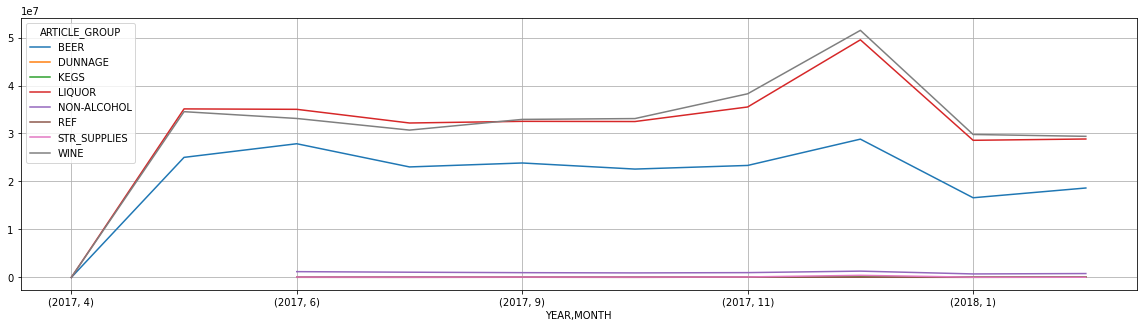

In [12]:
time_table['SALES'].plot()
plt.grid()
plt.show()

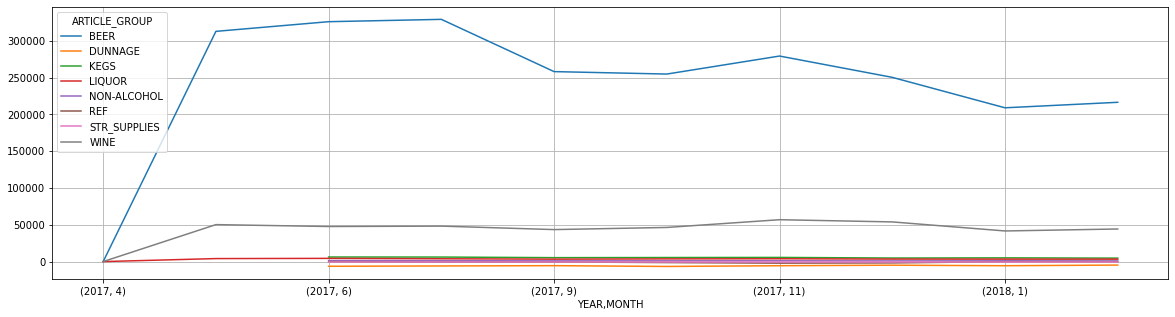

In [13]:
time_table['STORE_SALES'].plot()
plt.grid()
plt.show()

Данные представлены с апреля 2017 года по февраль 2018 года, причем первый месяц (апрель 2017) бесполезен, в нем нет продаж.  
Отсутсвуют данные за июль 2017. 
Среди прочих месяцев сильно выделяется декабрь - время закупок к праздникам.  
STORE_SALES сильно ниже, чем SALES, там в основном пиво и немного вина. Что означает этот признак? На Same Store Sales / Comparable Store Sales не похоже - слишком сильно отличается от SALES распределение по месяцам и группам. Продажи одной точки? Продажи со склада (оптовые)? Корреляция между STORE_SALES и SALES неплохая - 0.46, но думаю, что использовать STORE_SALES за тот месяц, на который делается прогноз - это подглядывание. В отсутствии дополнительной информации о STORE_SALES не буду использовать его в модели.

В целом задачу понимаю так: спрогнозировать продажи каждого товара в феврале 2018 (тестовая выборка), используя данные о его продажах с мая 2017 по январь 2018 включительно. ТТо, что данные сгруппированы по месяцам и даны меньше, чем за год, не даст разделить тренд и сезонность. Как вариант, можно попробовать учесть сезонные колебания продаж на базе других открытых данных, например отсюда: https://ac.gov.ru/publications/topics/topic/13658?page=1.

Вижу три варианта решения задачи плюс их комбинации:
- наивный подход: для каждого объекта в качестве предсказания использовать продажи за предыдущий месяц / усредненные за предыдущие месяца;
- использовать данные в том виде, в каком они даны, надеясь, что модель найдет закономерности. В этом случае делим данные на обучающую и тестовую выборки по месяцам;
- сгруппировать продажи по продуктам и месяцам. В этом случае признаками обучающей выборки будут продажи с мая по декабрь 2017 года, а целевым признаком - продажи в январе 2018 года. Признаками тестовой выборки - продажи с июня 2017 по январь 2018 года.

### Предобработка

#### Пропуски и дубликаты
Пропущено одно значение в ARTICLE_GROUP

In [14]:
df[df['ARTICLE_GROUP'].isnull()]

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
66439,2017,10,REPUBLIC NATIONAL DISTRIBUTING CO,347939,FONTANAFREDDA BAROLO SILVER LABEL 750 ML,NaN,0.0,1.0


Очевидно это вино, заполним пропуск вручную

In [15]:
df.loc[66439,'ARTICLE_GROUP'] = 'WINE'

Пропуски в CONTRAGENT

In [16]:
df[df['CONTRAGENT'].isnull()]

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
19483,2017,6,NaN,1279,EMPTY WINE KEG - KEGS,DUNNAGE,0.0,-9.0
20056,2017,8,NaN,1279,EMPTY WINE KEG - KEGS,DUNNAGE,0.0,-5.0
32282,2017,6,NaN,BC,BEER CREDIT,REF,0.0,-58.0
32283,2017,6,NaN,WC,WINE CREDIT,REF,0.0,-8.0
45871,2017,8,NaN,BC,BEER CREDIT,REF,0.0,-699.0
45872,2017,8,NaN,WC,WINE CREDIT,REF,0.0,-5.0
46518,2017,9,NaN,1279,EMPTY WINE KEG - KEGS,DUNNAGE,0.0,-9.0
59259,2017,9,NaN,BC,BEER CREDIT,REF,0.0,-502.0
59260,2017,9,NaN,WC,WINE CREDIT,REF,0.0,-15.0
59920,2017,10,NaN,1279,EMPTY WINE KEG - KEGS,DUNNAGE,0.0,-6.0


Все пропуски относятся к BEER CREDIT, WINE CREDIT, EMPTY WINE KEG - KEGS. Заполним их значением 'No'

In [17]:
df['CONTRAGENT'].fillna('No', inplace=True)

Дубликаты отсутствуют

In [18]:
df.duplicated().sum()

0

### Анализ

In [19]:
df['SALES'].describe()

count    1.283550e+05
mean     6.563037e+03
std      2.892494e+04
min     -6.490000e+03
25%      0.000000e+00
50%      3.300000e+02
75%      3.250000e+03
max      1.616600e+06
Name: SALES, dtype: float64

In [20]:
df['STORE_SALES'].describe()

count    128355.000000
mean         22.624213
std         239.693277
min       -4996.000000
25%           0.000000
50%           1.000000
75%           4.000000
max       16271.750000
Name: STORE_SALES, dtype: float64

<AxesSubplot:>

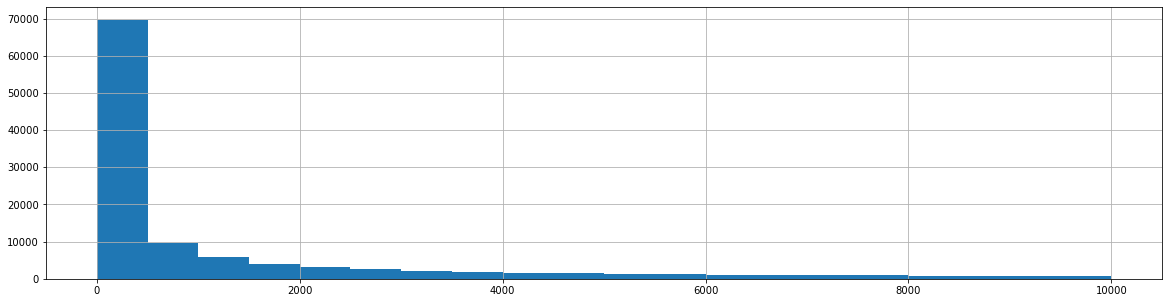

In [21]:
df['SALES'].hist(bins=20, range=(0,10000))

<AxesSubplot:>

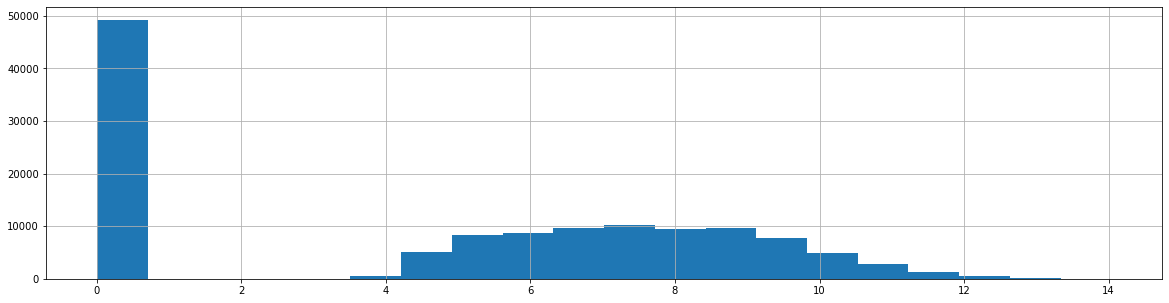

In [38]:
np.log1p(df['SALES']).hist(bins=20)

#### Отрицательные продажи

In [22]:
df[df['SALES']<0]

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
9310,2017,5,PARK STREET IMPORTS LLC,314022,TANTEO CHIPOTLE TEQUILA - 750ML,LIQUOR,-1000.0,0.0
13439,2017,5,BACCHUS IMPORTERS LTD,41740,CLEAR CREEK S/M WHISKEY - 750ML,LIQUOR,-80.0,0.0
14361,2017,5,MHW LTD,46382,BOL'S CREME DE MINT WHITE - 750ML,LIQUOR,-80.0,0.0
14388,2017,5,PRESTIGE BEVERAGE GROUP OF MD LLC,46545,CATOCTIN CREEK MOSBYS SPIRIT - 750ML,LIQUOR,-1000.0,0.0
16099,2017,5,BACCHUS IMPORTERS LTD,72334,DOM CICCIO AND FIGLI FINOCCHIETO - 750ML,LIQUOR,-170.0,0.0
16623,2017,5,CAMPARI AMERICA LLC,77280,GRAND MARNIER 1880 - 750ML,LIQUOR,-160.0,0.0
17448,2017,5,DELICATO FAMILY VINEYARDS,82797,MASSIMO NEW ZELAND S/BLC - 750ML,WINE,-80.0,0.0
22389,2017,6,REPUBLIC NATIONAL DISTRIBUTING CO,30970,BRANCOTT MARL P/NOIR - 750ML,WINE,-250.0,0.0
26916,2017,6,MHW LTD,414050,FEUDI D'ALBE MONTEPUL D'ABRU - 750ML,WINE,-770.0,15.0
27136,2017,6,JIM BEAM BRANDS CO,42412,DEKUYPER SIGN VANILLA DELIGHT - 750ML,LIQUOR,-10.0,0.0


In [23]:
df[df['SALES']<0]['CONTRAGENT'].value_counts().head(10)

REPUBLIC NATIONAL DISTRIBUTING CO    6
A VINTNERS SELECTIONS                6
SOUTHERN GLAZERS WINE AND SPIRITS    4
MHW LTD                              3
DIAGEO NORTH AMERICA INC             3
JIM BEAM BRANDS CO                   2
BACCHUS IMPORTERS LTD                2
LEGENDS LTD                          2
LANTERNA DISTRIBUTORS INC            2
CAMPARI AMERICA LLC                  1
Name: CONTRAGENT, dtype: int64

In [24]:
df['CONTRAGENT'].value_counts().head(20)

REPUBLIC NATIONAL DISTRIBUTING CO         9847
A VINTNERS SELECTIONS                     8716
LEGENDS LTD                               5494
SOUTHERN GLAZERS WINE AND SPIRITS         4713
E & J GALLO WINERY                        4669
BACCHUS IMPORTERS LTD                     4383
MONSIEUR TOUTON SELECTION                 4259
DIAGEO NORTH AMERICA INC                  3333
RELIABLE CHURCHILL LLLP                   2864
CONSTELLATION BRANDS                      2851
JIM BEAM BRANDS CO                        2743
DOPS INC                                  2503
PERNOD RICARD USA LLC                     2404
ANHEUSER BUSCH INC                        2143
CONSTANTINE WINES INC                     1985
OPICI FAMILY DISTRIBUTING OF MD           1943
PRESTIGE BEVERAGE GROUP OF MD LLC         1890
TREASURY WINE ESTATES AMERICAS COMPANY    1812
THE WINE GROUP                            1770
DIONYSOS IMPORTS INC                      1668
Name: CONTRAGENT, dtype: int64

Отрицательных продаж немного. Систематики не видно: они равномерно распределены по месяцам, распределение по контрагентам соответствует частоте контрагентов. Предполагаю, что это случайные ошибки, обнулим их.

In [25]:
df.loc[(df['SALES']<0), 'SALES'] = 0

#### Продажи за декабрь
Декабрь - традиционное время высоких продаж. Нам не нужно его предсказывать, но нужно на нем обучаться. Чтобы модели, учитывающие продажи за предыдущие месяцы, не ошибались из-за декабрьских продаж, нормируем суммы продаж за декабрь. При расчете среднего значения нельзя использовать данные за февраль 2018 года.

In [26]:
time_table = df[df['MONTH']!=2].pivot_table(index=['YEAR','MONTH'], values='SALES', columns='ARTICLE_GROUP', aggfunc='sum')
time_table

ARTICLE_GROUP        BEER  DUNNAGE  KEGS      LIQUOR  NON-ALCOHOL      REF  \
YEAR MONTH                                                                   
2017 4                0.0      NaN   NaN         0.0          0.0      0.0   
     5         25023240.0      NaN   NaN  35125850.0          NaN      NaN   
     6         27863260.0      0.0   0.0  35039790.0    1209230.0  30600.0   
     8         23030130.0      0.0   0.0  32186210.0    1091280.0  19540.0   
     9         23852760.0      0.0   0.0  32532650.0     997110.0  38880.0   
     10        22583910.0      0.0   0.0  32491590.0     945630.0  22820.0   
     11        23341140.0      0.0   0.0  35528430.0    1005190.0  63110.0   
     12        28822160.0      0.0   0.0  49522370.0    1316440.0  41210.0   
2018 1         16606420.0      0.0   0.0  28579880.0     732250.0  23660.0   

ARTICLE_GROUP  STR_SUPPLIES        WINE  
YEAR MONTH                               
2017 4                  0.0         0.0  
     5                  NaN  34546970.0  
     6              89220.0  33138070.0  
     8              77340.0  30709780.0  
     9              94640.0  32938040.0  
     10             84380.0  33108760.0  
     11            106060.0  38279090.0  
     12            439640.0  51493350.0  
2018 1              56940.0  29793880.0

In [27]:
k_december = pd.Series(dtype='float')

for group in time_table:
    mean_val = time_table.where(time_table!=0)[group].mean()
    dec_val = time_table.loc[2017,group][12]
    k = mean_val/dec_val
    k_december[group] = k
    
k_december

BEER            0.828889
DUNNAGE              NaN
KEGS                 NaN
LIQUOR          0.709293
NON-ALCOHOL     0.791868
REF             0.831352
STR_SUPPLIES    0.308116
WINE            0.689429
dtype: float64

In [28]:
for group in ['BEER', 'LIQUOR', 'NON-ALCOHOL', 'REF', 'STR_SUPPLIES', 'WINE']:
    idx = df[(df['ARTICLE_GROUP']==group) & (df['MONTH']==12)].index
    df.loc[idx,'SALES'] *= k_december[group]

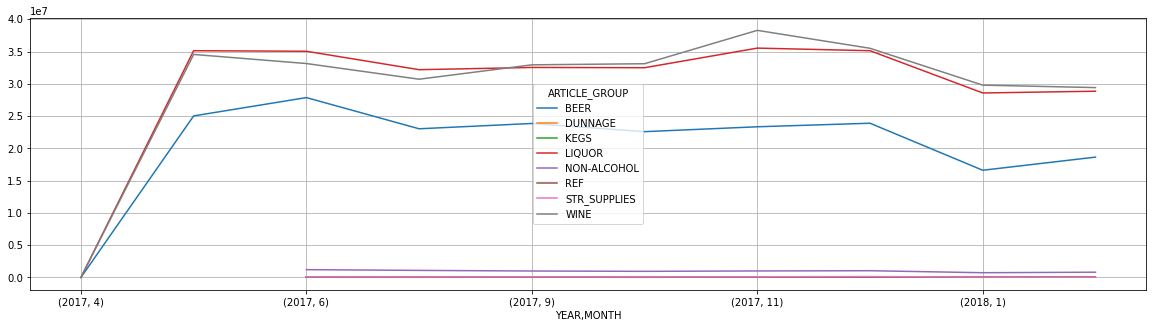

In [29]:
time_table = df.pivot_table(index=['YEAR','MONTH'], values='SALES', columns='ARTICLE_GROUP', aggfunc='sum')
time_table.plot()
plt.grid()
plt.show()

#### Логарифм продаж

In [40]:
df['LOGSALES'] = np.log1p(df['SALES'])
df

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,SEASON,LOGSALES
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0,spring,0.000000
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0,spring,0.000000
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0,spring,0.000000
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0,spring,0.000000
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0,spring,0.000000
...,...,...,...,...,...,...,...,...,...,...
128350,2018,2,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,66460.0,212.0,winter,11.104371
128351,2018,2,COASTAL BREWING COMPANY LLC,99970,DOMINION OAK BARREL STOUT 4/6 NR - 12OZ,BEER,9080.0,35.0,winter,9.113940
128352,2018,2,BOSTON BEER CORPORATION,99988,SAM ADAMS COLD SNAP 1/6 KG,KEGS,0.0,32.0,winter,0.000000
128353,2018,2,No,BC,BEER CREDIT,REF,0.0,-35.0,winter,0.000000


#### Сезон в качестве дополнительного признака
Декабрь выделяется отдельно.
Была мысль, что это поможет деревьям хоть как-то найти взаимосвязь между месяцами, но не сыграло.

In [30]:
df['SEASON'] = df['MONTH']
seasons = {1: 'winter',
           2: 'winter',
           3: 'spring',
           4: 'spring',
           5: 'spring',
           6: 'summer', 
           7: 'summer', 
           8: 'summer', 
           9: 'autumn', 
           10: 'autumn', 
           11: 'autumn', 
           12: 'december'}
df['SEASON'].replace(seasons, inplace=True)
df

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,SEASON
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0,spring
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0,spring
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0,spring
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0,spring
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0,spring
...,...,...,...,...,...,...,...,...,...
128350,2018,2,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,66460.0,212.0,winter
128351,2018,2,COASTAL BREWING COMPANY LLC,99970,DOMINION OAK BARREL STOUT 4/6 NR - 12OZ,BEER,9080.0,35.0,winter
128352,2018,2,BOSTON BEER CORPORATION,99988,SAM ADAMS COLD SNAP 1/6 KG,KEGS,0.0,32.0,winter
128353,2018,2,No,BC,BEER CREDIT,REF,0.0,-35.0,winter


Данные о товарах сохраним в таблице product_table

In [31]:
product_table = df[['ARTICLE_CODE','ARTICLE_NAME','ARTICLE_GROUP',
    'CONTRAGENT']].drop_duplicates(subset='ARTICLE_CODE').set_index('ARTICLE_CODE')
product_table

,ARTICLE_NAME,ARTICLE_GROUP,CONTRAGENT
ARTICLE_CODE,,,
100200,GAMLA CAB - 750ML,WINE,ROYAL WINE CORP
100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,SANTA MARGHERITA USA INC
10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,JIM BEAM BRANDS CO
10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,HEAVEN HILL DISTILLERIES INC
101664,RAMON CORDOVA RIOJA - 750ML,WINE,ROYAL WINE CORP
...,...,...,...
87364,BAREFOOT CEL ROSE - 187ML,WINE,E & J GALLO WINERY
88399,TENSHEN WHITE BLEND - 750ML,WINE,RELIABLE CHURCHILL LLLP
88400,SEAGRAM SPIKED STRWBRRY DAIQURI 12/23.5OZ CAN,BEER,LABATT USA OPERATING CO LLC


### Подготовка выборок

В тестовую выборку по условию задания попадут продажи за последний месяц (февраль 2018). Т.к. имеем дело с изменяющимися во времени данными, в качестве валидационной выборки возьмем предпоследний месяц (январь 2018).

In [41]:
test = df[df['MONTH']==2]
valid = df[df['MONTH']==1]
train = df[df['MONTH']>4]
train_full = train.append(valid)
train.shape, valid.shape, train_full.shape, test.shape

((96715, 10), (13345, 10), (110060, 10), (13100, 10))

### Подбор модели
#### Наивный подход
Прогноз через продажи за прошлый месяц

In [42]:
def pred_by_previous(train_month, test_month):
    
    y = df[df['MONTH']==test_month][['ARTICLE_CODE','SALES']]
    product_table = df[df['MONTH']==train_month]
    pred = product_table[['ARTICLE_CODE','SALES']].merge(y['ARTICLE_CODE'], 
                                                         on='ARTICLE_CODE', how='right').set_index(y.index)
    pred = pred['SALES'].fillna(0)
    return y['SALES'], pred

In [43]:
y_valid, pred = pred_by_previous(12, 1)
metric(y_valid, pred)

45.11399404530055

Прогноз через среднемесячное значение для каждого товара

In [44]:
def pred_by_mean(train_month, test_month):
    
    y = df[df['MONTH']==test_month][['ARTICLE_CODE','SALES']]
    pred = df[df['MONTH'].isin(train_month)].pivot_table(index='ARTICLE_CODE', values='SALES', aggfunc='mean')
    pred = pred.merge(y['ARTICLE_CODE'], left_index=True, right_on='ARTICLE_CODE', how='right')
    pred = pred['SALES'].fillna(0)
    return y['SALES'], pred

In [45]:
y_valid, pred = pred_by_mean([9,10,11,12], 1)
metric(y_valid, pred)

39.159429621444566

На валидации лучший результат получен усреднением значений четырех предыдущих месяцев.

#### Обучение на признаках исходного датасета

Так как все признаки категориальные, будем работать с деревьями, использовать порядковое кодирование

In [67]:
feat_cols = ['CONTRAGENT', 'ARTICLE_CODE', 'ARTICLE_GROUP']
X_train1 = train[feat_cols]
y_train1 = train['SALES']
X_valid1 = valid[feat_cols]
y_valid1 = valid['SALES']
print('train:', X_train1.shape, y_train1.shape)
print('valid:', X_valid1.shape, y_valid1.shape)

train: (96715, 3) (96715,)
valid: (13345, 3) (13345,)


In [68]:
X_train1.head()

,CONTRAGENT,ARTICLE_CODE,ARTICLE_GROUP
2689,DOPS INC,12644,WINE
2913,Default,59978,REF
2989,DOPS INC,7102,BEER
3547,LEGENDS LTD,8214,BEER
3732,LEGENDS LTD,99090,KEGS


In [69]:
encoder = OrdinalEncoder(dtype='int32')
encoder.fit(df[feat_cols])
X_train1[feat_cols] = encoder.transform(X_train1[feat_cols])
X_valid1[feat_cols] = encoder.transform(X_valid1[feat_cols])
X_train1.head()

<ipython-input-69-a761096a5bce>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train1[feat_cols] = encoder.transform(X_train1[feat_cols])
C:\Users\albri\.conda\envs\python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\albri\.conda\envs\python38\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,CONTRAGENT,ARTICLE_CODE,ARTICLE_GROUP
2689,86,1170,7
2913,93,19028,5
2989,86,20020,0
3547,168,21866,0
3732,168,23506,2


Decision Tree

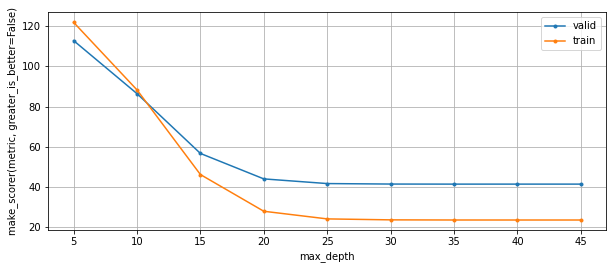

Best valid score: 41.46319039075605
Best params: {'max_depth': 35}


,valid,train
{'max_depth': 5},112.828,121.896
{'max_depth': 10},86.442,88.301
{'max_depth': 15},56.722,46.229
{'max_depth': 20},44.063,27.972
{'max_depth': 25},41.741,24.175
{'max_depth': 30},41.500,23.699
{'max_depth': 35},41.463,23.630
{'max_depth': 40},41.468,23.624
{'max_depth': 45},41.466,23.624


In [70]:
model = DecisionTreeRegressor(random_state=123)
params = {'max_depth': range(5,50,5)}
gridSearch(X_train1, y_train1, X_valid1, y_valid1, model, custom_scorer, params, check_train=True)

In [71]:
model = DecisionTreeRegressor(random_state=123)
model.fit(X_train1, y_train1)
pred = model.predict(X_valid1)
metric(y_valid, pred)

41.46577757258527

In [72]:
model = DecisionTreeRegressor(random_state=123)
model.fit(X_train1, np.log1p(y_train1))
pred = model.predict(X_valid1)
pred = np.expm1(pred)
metric(y_valid, pred)

46.006602431850816

RandomForest

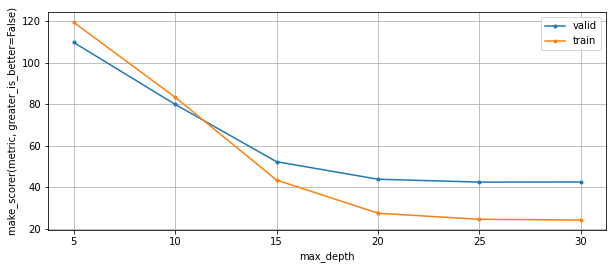

Best valid score: 42.36968240193381
Best params: {'max_depth': 25}
Wall time: 19 s


,valid,train
{'max_depth': 5},109.715,119.380
{'max_depth': 10},79.873,83.305
{'max_depth': 15},52.199,43.355
{'max_depth': 20},43.760,27.376
{'max_depth': 25},42.370,24.421
{'max_depth': 30},42.424,24.094


In [41]:
%%time
model = RandomForestRegressor(random_state=123, n_jobs=-1)
params = {'max_depth': range(5,31,5)}
gridSearch(X_train1, y_train1, X_valid1, y_valid1, model, custom_scorer, params, check_train=True)

LightGBM

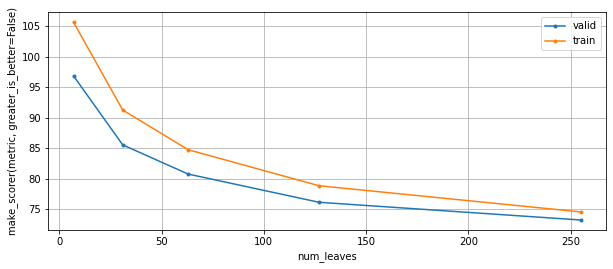

Best valid score: 73.25646025895558
Best params: {'num_leaves': 255}


,valid,train
{'num_leaves': 7},96.825,105.603
{'num_leaves': 31},85.555,91.262
{'num_leaves': 63},80.775,84.757
{'num_leaves': 127},76.157,78.864
{'num_leaves': 255},73.256,74.578


In [42]:
model = lgb.LGBMRegressor(random_state=123, learning_rate=0.5, n_jobs=-1)
params = {'num_leaves': [7,31,63,127,255]}
gridSearch(X_train1, y_train1, X_valid1, y_valid1, model, custom_scorer, params, check_train=True)

Модели, обученные по исходному датасету, показали результат хуже, чем при прогнозировании среднего значения. Ключевой признак - ARTICLE_CODE. Фактически модель пытается запомнить одно оптимальное (усредненное) значение для каждого продукта, т.е. она ничем не лучше наивного регрессерора.    
Ансамбли проигрывают обычному дереву решений.

#### Обучение на признаках, сгруппированных по продуктам

In [43]:
def create_features(prev_month, last_month):
    
    y = df[df['MONTH']==last_month][['ARTICLE_CODE','SALES']]
    y = y.set_index('ARTICLE_CODE')['SALES']
    
    X = df.pivot_table(index=['ARTICLE_CODE'], values='SALES', columns='MONTH', aggfunc='sum', fill_value=0)
    X = X[prev_month]
    #X = X.join(product_table[['ARTICLE_GROUP']])
    X = X.loc[y.index]
    
    return X, y

In [44]:
X_train2, y_train2 = create_features([8,9,10,11], 12)
X_valid2, y_valid2 = create_features([9,10,11,12], 1)
print(X_train2.shape, y_train2.shape)
print(X_valid2.shape, y_valid2.shape)

(14500, 4) (14500,)
(13345, 4) (13345,)


In [45]:
scaler = StandardScaler()
X_train2[X_train2.columns] = scaler.fit_transform(X_train2[X_train2.columns])
X_valid2[X_valid2.columns] = scaler.transform(X_valid2[X_valid2.columns])
#X_train2 = pd.get_dummies(X_train2, columns=['ARTICLE_GROUP'], drop_first=True)
#X_valid2 = pd.get_dummies(X_valid2, columns=['ARTICLE_GROUP'], drop_first=True)
X_train2

MONTH,8,9,10,11
ARTICLE_CODE,,,,
31177,-0.221248,-0.218065,-0.225596,-0.241230
100009,-0.221248,-0.218065,-0.225596,-0.241230
100012,-0.221248,-0.218065,-0.225596,-0.241230
100080,-0.221248,-0.218065,-0.225596,-0.241230
1001,-0.221248,-0.218065,-0.225596,-0.241230
...,...,...,...,...
9997,3.129390,2.541331,2.698020,2.673478
99970,0.216196,0.215079,0.292513,0.365554
99988,-0.221248,-0.218065,-0.225596,-0.241230


In [46]:
model = LinearRegression()
res = gridSearch(X_train2, y_train2, X_valid2, y_valid2, model, custom_scorer, check_train=True)

Best valid score: 40.835068396916725


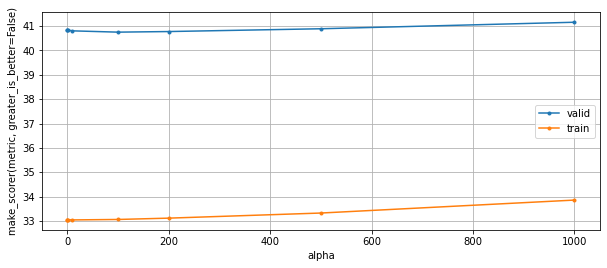

Best valid score: 40.7476889777715
Best params: {'alpha': 100}


,valid,train
{'alpha': 0.01},40.835,33.060
{'alpha': 0.1},40.835,33.059
{'alpha': 1},40.831,33.058
{'alpha': 10},40.801,33.049
{'alpha': 100},40.748,33.068
{'alpha': 200},40.772,33.121
{'alpha': 500},40.887,33.331
{'alpha': 1000},41.154,33.862


In [47]:
model = Lasso()
params = {'alpha': [0.01,0.1,1,10,100,200,500,1000]}
gridSearch(X_train2, y_train2, X_valid2, y_valid2, model, custom_scorer, params, check_train=True)

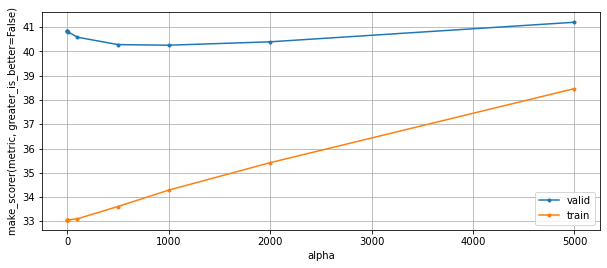

Best valid score: 40.25477021040813
Best params: {'alpha': 1000}


,valid,train
{'alpha': 0.01},40.835,33.060
{'alpha': 0.1},40.835,33.059
{'alpha': 1},40.832,33.059
{'alpha': 10},40.803,33.059
{'alpha': 100},40.585,33.105
{'alpha': 500},40.280,33.611
{'alpha': 1000},40.255,34.286
{'alpha': 2000},40.395,35.416
{'alpha': 5000},41.201,38.468


In [48]:
model = Ridge()
params = {'alpha': [0.01,0.1,1,10,100,500,1000,2000,5000]}
gridSearch(X_train2, y_train2, X_valid2, y_valid2, model, custom_scorer, params, check_train=True)

In [49]:
model = Ridge(alpha=1000)
model.fit(X_train2, y_train2)
model.coef_

array([ 3784.77780493,  6710.29861569,  5037.62434817, 11799.2472818 ])

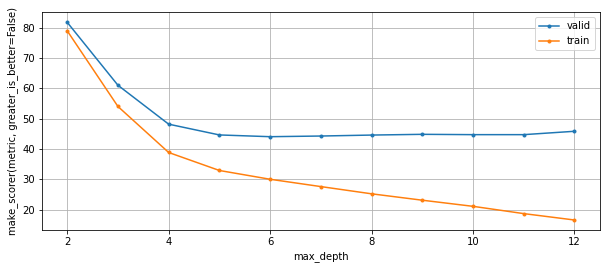

Best valid score: 44.02352137344809
Best params: {'max_depth': 6}


,valid,train
{'max_depth': 2},81.742,78.940
{'max_depth': 3},60.988,53.987
{'max_depth': 4},48.155,38.814
{'max_depth': 5},44.602,32.880
{'max_depth': 6},44.024,29.982
{'max_depth': 7},44.246,27.568
{'max_depth': 8},44.563,25.185
{'max_depth': 9},44.806,23.076
{'max_depth': 10},44.699,21.056
{'max_depth': 11},44.699,18.654


In [50]:
model = DecisionTreeRegressor()
params = {'max_depth': range(2,13)}
gridSearch(X_train2, y_train2, X_valid2, y_valid2, model, custom_scorer, params, check_train=True)

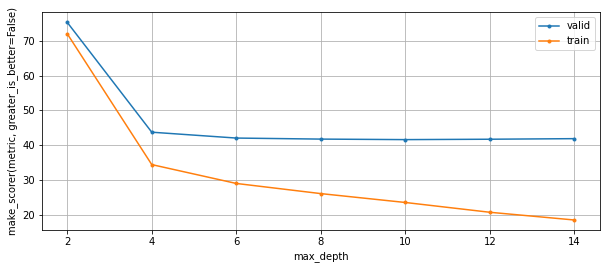

Best valid score: 41.588742887569516
Best params: {'max_depth': 10}


,valid,train
{'max_depth': 2},75.278,72.006
{'max_depth': 4},43.720,34.414
{'max_depth': 6},42.036,28.994
{'max_depth': 8},41.738,26.079
{'max_depth': 10},41.589,23.527
{'max_depth': 12},41.701,20.715
{'max_depth': 14},41.867,18.495


In [51]:
model = RandomForestRegressor()
params = {'max_depth': range(2,15,2)}
gridSearch(X_train2, y_train2, X_valid2, y_valid2, model, custom_scorer, params, check_train=True)

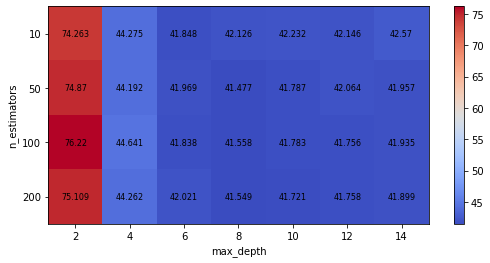

Best valid score: 41.47662037251351
Best params: {'max_depth': 8, 'n_estimators': 50}


In [52]:
model = RandomForestRegressor()
params = {'n_estimators': [10,50,100,200], 'max_depth': range(2,15,2)}
res = gridSearch(X_train2, y_train2, X_valid2, y_valid2, model, custom_scorer, params, check_train=True)

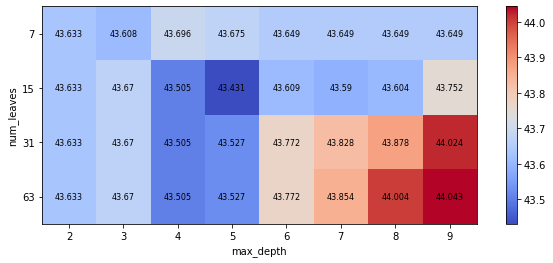

Best valid score: 43.431128892165596
Best params: {'max_depth': 5, 'num_leaves': 15}


In [53]:
model = lgb.LGBMRegressor(random_state=123, learning_rate=0.1, n_jobs=-1)
params = {'num_leaves': [7,15,31,63], 'max_depth': range(2,10)}
res = gridSearch(X_train2, y_train2, X_valid2, y_valid2, model, custom_scorer, params, check_train=True)

Лучший результат получен при использовании продаж за четыре предыдущих месяца. Добавление категориальных признаков (ARTICLE_GROUP, CONTRAGENT) не помогает улучшить скор.  
Удалось подобрать Ridge, который при валидации показал результат немного лучше, чем наивный регрессор.

### Тестирование модели

In [54]:
X_test1 = test[feat_cols]
y_test1 = test['SALES']
X_train_full1 = train_full[feat_cols]
y_train_full1 = train_full['SALES']
X_train_full1[feat_cols] = encoder.transform(X_train_full1[feat_cols])
X_test1[feat_cols] = encoder.transform(X_test1[feat_cols])

<ipython-input-54-ac43a585b3b0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_full1[feat_cols] = encoder.transform(X_train_full1[feat_cols])
C:\Users\albri\.conda\envs\python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\albri\.conda\envs\python38\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

Наивный регрессор с предсказанием по среднему значению для каждого товара

In [55]:
y_test, pred_naiv = pred_by_mean([10,11,12,1], 2)
metric(y_test, pred_naiv)

31.708886063324893

Дерево для исходного датасета

In [56]:
model = DecisionTreeRegressor(max_depth=35, random_state=123)
model.fit(X_train_full1, y_train_full1)
pred_test1 = model.predict(X_test1)
metric(y_test1, pred_test1)

35.30729661257103

Ridge для датасета, сгруппированного по товарам

In [57]:
X_train_full2, y_train_full2 = create_features([8,9,10,11,12], 1)
X_test2, y_test2 = create_features([9,10,11,12,1], 2)

In [58]:
model = Ridge(alpha=1000)
model.fit(X_train_full2, y_train_full2)
pred_test2 = model.predict(X_test2)
metric(y_test2, pred_test2)

38.60895912341288

### Выводы

Чтобы показать нестабильность полченного результата, я прогнал тестовую выборку через все полученные модели. На тесте полноценные модели оказались хуже наивного регрессора, предсказывающего усредненное значение продаж, что свидетельствует об их неадекватности. Увы.   
Специфика задачи - мало исторических данных для каждого товара, но также и малое окно прогноза. Невозможно учесть тренды и сезонность, чтобы скорректировать, куда качнутся продажи в следующем месяце. Думаю, именно поэтому модели оказались недостаточно хороши.